<a href="https://colab.research.google.com/github/serereuk/Paper_Review/blob/master/pbt_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reference from http://ash-aldujaili.github.io/blog/2018/03/15/pbt/

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Objective Function 

---



$Q(\theta$) = 1.2 - ($\theta _0^2$ + $\theta _1^2)$

In [0]:
def q(theta):
    return 1.2 - np.sum(np.array(theta)**2)

우리의 목표함수는 저렇게 생겼지만 하지만 인생이 그렇듯 저 함수에 대해서 우리가 직접 발견할 수는 없음 ㅠ

그래서 다음 과 같은 유사 함수로 저 함수의 max를 찾아볼 예정

# Objective Function hat


---


$Q(\hat\theta$|h) = 1.2 - ($h_0$$\theta _0^2$ + $h_1$$\theta _1^2)$

In [0]:
def q_hat(theta, h):
    return 1.2 - np.sum(np.dot(np.array(h), np.array(theta)**2))

아래의 코드를 사용해서 해볼 것입니당!

In [0]:
"""
Population Modeling
병렬적으로 만들 친구들 만드는 부분
"""
class Member(object):
    def __init__(self, theta=[0., 0.], h=[0., 0.], _id=1, _eta=0.01, _sigma=1e-1):
        """
        input:
            theta : theta 값
            h : h값
            _id : population 번호
            _eta : Learning rate와 비슷한 역할을 하는듯
            _sigma : eps와 같은 역할...?
        """
        self.theta = theta
        self.h = h
        self.id = _id
        self.num_steps = 0
        self.p = q(self.theta)
        self._eta = _eta
        self._sigma = _sigma
        ## for visualization
        self.trace = []
        self.ps = [self.p]

    def eval(self): # 평가를 object 함수로 진행
        self.p = q(self.theta)

    def ready(self): # mutate 친구 같은 것을 언제 할 것인지(Exploit, and Explore)
        return self.num_steps > 10

    def step(self): # one step to optimization 
        for i in range(2):
            self.theta[i] +=  self._eta * (-2. * self.h[i] * self.theta[i])
        self.num_steps += 1

    def explore(self): # Mutate 진행
        for i in range(2):
            self.h[i] = np.clip(self.h[i] + self._sigma * np.random.randn(), 0, 1)

    def exploit(self, other): # 다른 친구의 값을 사용!
        if self.p <= other.p:
            self.theta = list(other.theta)
            self.p = other.p
            self.num_steps = 0
            return True
        else:
            return False

    def log(self): # 로그 찍기
        self.trace.append(list(self.theta))
        self.ps.append(self.p)

    def __str__(self):
        return 'theta:' + '%.2f' % self.theta[0] + ',%.2f' % self.theta[1] + \
               '| h:' + '%.2f' % self.h[0] + ',%.2f' % self.h[1] + '| id' + str(self.id) + \
               '| p:' + '%.2f' % self.p + '| steps:' + str(self.num_steps)

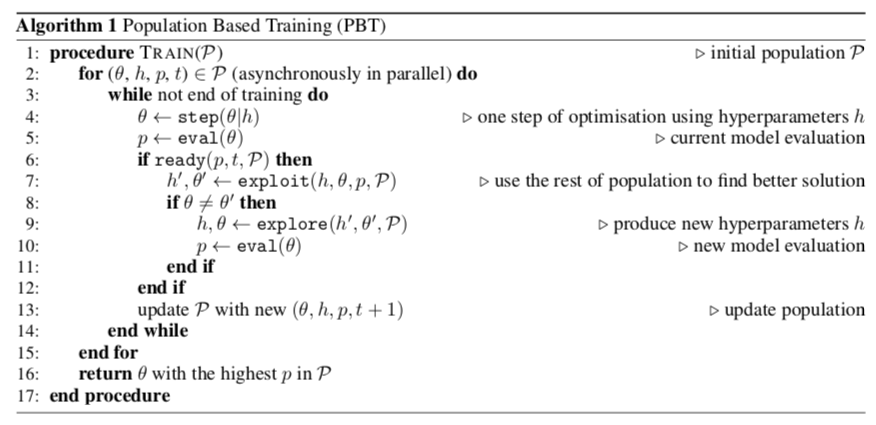

In [0]:
def pbt(grid=False, explore_only=False, exploit_only=False):
    # a check to ensure only one mode is selected for PBT
    assert grid + exploit_only + explore_only <= 1, "at most one flag can be set for PBT modes"
    # init population
    population = [
        Member(theta=[0.9, 0.9], h=[0,1], _id=0),
        Member(theta=[0.9, 0.9], h=[1,0], _id=1)
        ]
    member_ids = np.arange(len(population))
    # begin training
    for _ in range(75):
        np.random.shuffle(member_ids)
        for mem_id in member_ids:
            member = population[mem_id]
            member.step()
            member.eval()
            if member.ready() and not grid:
                if explore_only:
                    member.explore()
                else:
                    member.exploit(population[(mem_id + 1) % 2])
                    if not exploit_only:
                        member.explore()
                    member.eval()
            member.log()

    traces = [population[i].trace for i in range(len(population))]
    ps = [population[i].ps for i in range(len(population))]
    return traces, ps

In [0]:
def plot_traces(ax, traces, title):
    for i in traces:
        ax.scatter(np.array(i)[:,0],np.array(i)[:,1], s = 10)
    ax.set_ylim([0,1])
    ax.title.set_text(title)

def plot_curves(ax, ps, title):
    for i in ps:
        ax.plot(i)
    ax.set_ylim([0,1])
    ax.yaxis.label.set_size(1)
    ax.title.set_text(title)

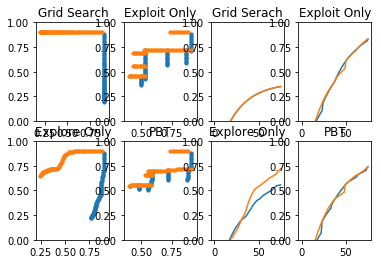

In [0]:
f, axes = plt.subplots(2, 4)#, sharex=True)

traces, ps = pbt(grid=True)
plot_traces(axes[0,0], traces, title='Grid Search')
plot_curves(axes[0,2], ps, title='Grid Serach')
del traces, ps

traces, ps = pbt(exploit_only=True)
plot_traces(axes[0,1], traces, title='Exploit Only')
plot_curves(axes[0,3], ps, title='Exploit Only')

traces, ps = pbt(explore_only=True)
plot_traces(axes[1,0], traces, title='Explore Only')
plot_curves(axes[1,2], ps, title='Explore Only')

traces, ps = pbt()
plot_traces(axes[1,1], traces, title='PBT')
plot_curves(axes[1,3], ps, title='PBT')

plt.show()